In [1]:
using GrootSim

using CSV
using DataFrames
using Dates
using DotEnv
DotEnv.load!()
using PyPlot
using Serialization
using SimpleHypergraphs
using Statistics

using PyCall
pickle = pyimport("pickle");

Precompiling GrootSim
  ✓ GrootSim
  1 dependency successfully precompiled in 5 seconds. 89 already precompiled.


## Loading data

In [3]:
function load_params(precomputed_path; subreddits_to_include=nothing)
    # * reddit-related params
    basepath = ENV["BASEPATH"]
    datapath = ENV["DATA_PATH"]
    data_to_include_path = ENV["DATA_TO_INCLUDE_PATH"]

    # * loading the data
    reddittors_to_include = Set(pickle.load(open(joinpath(data_to_include_path, "final_users_to_include.pkl"))))
    subs_to_include = (pickle.load(open(joinpath(data_to_include_path, "final_subs_to_include.pkl"))))
    subs_to_include = Set([sub_id[4:end] for sub_id in subs_to_include])

    # * loading the most active users,
    # * namely the users with at least two actions
    most_active_users = deserialize(joinpath(precomputed_path, "most_active_users.ser"))

    # * loading the simulation intervals
    sim_intervals = deserialize(joinpath(precomputed_path, "sim_intervals.ser"))

    # * loading active intervals per users
    active_intervals_per_user = deserialize(joinpath(precomputed_path, "active_intervals_per_user.ser"))

    # * loading user opinions from ground-truth
    gt_user_opinions = get_true_user_stance(
        datapath,
        subs_to_include,
        reddittors_to_include;
        subreddits_to_include=subreddits_to_include
    )

    # * loading the user opinions per interval
    gt_user_opinions_per_interval = get_avg_user_opinion_per_interval(
        gt_user_opinions,
        sim_intervals
    )

    return most_active_users, sim_intervals, active_intervals_per_user, gt_user_opinions, gt_user_opinions_per_interval
end

load_params (generic function with 1 method)

In [4]:
precomputed_params_path = joinpath(ENV["PRECOMPUTED_PARAMS_PATH"], "day", "all");

In [5]:
most_active_users, sim_intervals, active_intervals_per_user, gt_user_opinions, gt_user_opinions_per_interval = 
    load_params(precomputed_params_path)


subreddit_name: AskReddit
subreddit_name: California
subreddit_name: bayarea
subreddit_name: collapse
subreddit_name: news
subreddit_name: politics


([:t2_12ggve, :t2_pdoeucf5, :t2_90b6qnh4, :t2_g8q34, :t2_4lewvnt3, :t2_dvl2ba5q, :t2_2jutnueu, :t2_icclc, :t2_m1iv6hg, :t2_2rrsi0i8  …  :t2_bidg8, :t2_obx4b, :t2_897wp, :t2_m26brs75, :t2_dp4h22a, :t2_11rbnv, :t2_4m62ya2u, :t2_11v20w, :t2_8mztllz6, :t2_ap53n], [DateTime("2020-07-01T13:18:10") => DateTime("2020-07-02T00:00:00"), DateTime("2020-07-02T13:42:05") => DateTime("2020-07-03T00:00:00"), DateTime("2020-07-02T13:42:05") => DateTime("2020-07-04T00:00:00"), DateTime("2020-07-04T11:22:19") => DateTime("2020-07-05T00:00:00"), DateTime("2020-07-05T17:44:15") => DateTime("2020-07-06T00:00:00"), DateTime("2020-07-06T21:46:47") => DateTime("2020-07-07T00:00:00"), DateTime("2020-07-07T22:34:04") => DateTime("2020-07-08T00:00:00"), DateTime("2020-07-08T20:10:43") => DateTime("2020-07-09T00:00:00"), DateTime("2020-07-09T01:21:59") => DateTime("2020-07-10T00:00:00"), DateTime("2020-07-10T17:51:48") => DateTime("2020-07-11T00:00:00")  …  DateTime("2022-12-17T00:36:19") => DateTime("2022-12-19T

## Get the last users' opinions in the GT

In [10]:
last_opinions = Array{Float64, 1}()

Float64[]

In [11]:
for user in most_active_users
    user_opinions = gt_user_opinions[user]
    sorted_user_opinions = sort(user_opinions, by=x->x[1])
    push!(last_opinions, user_opinions[end].second)
end

In [12]:
quantile(last_opinions, [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

7-element Vector{Float64}:
 0.0
 0.15
 0.3
 0.5
 0.5
 0.75
 0.9

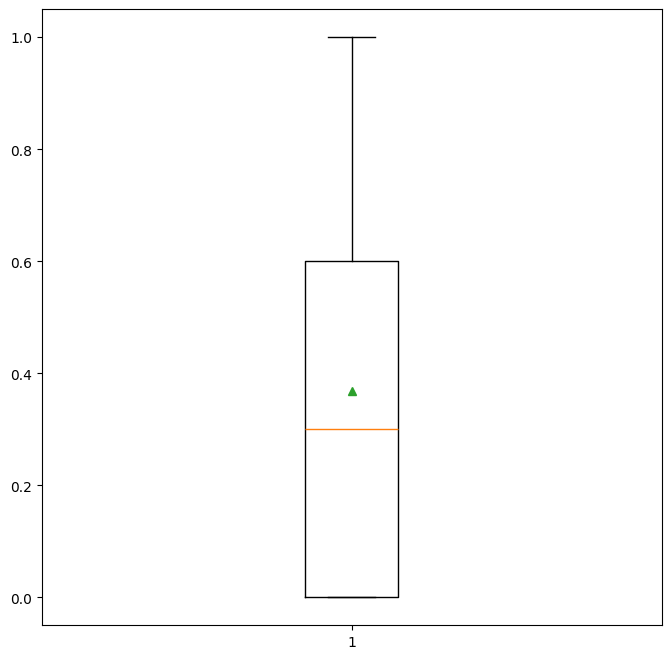

In [13]:
boxplot(last_opinions, showmeans=true, showfliers=false);

## Thrs vectors

In [14]:
my_step = 0.1

two_thrs = []
two_thrs_labels = []
for thr1 in 0.1:my_step:0.99
    for thr2 in 0.9:-my_step:0.1
        thr2 <= thr1 && continue
        push!(two_thrs, [-1.1, thr1, thr2, 1.1])
        push!(two_thrs_labels, "[$thr1, $thr2]")
    end
end

three_thrs = []
three_thrs_labels = []
for thr1 in 0.1:my_step:0.99
    for thr2 in 0.1:my_step:0.99
        thr2 <= thr1 && continue
        for thr3 in 0.1:my_step:0.99
            thr3 <= thr2 && continue
            push!(three_thrs, [-1.1, thr1, thr2, thr3, 1.1])
            push!(three_thrs_labels, "[$thr1, $thr2, $thr3]")
        end  
    end
end

## Plot-related utils

In [15]:
function prepare_data(opinions::Array{Array{Int, 1}, 1}, n_thrs)
    to_return = Array{Array{Float64, 1}, 1}()
    
    for (idx, _op) in enumerate(opinions)
        n_ops = length(_op) # this number should be equal to the number of users
        # idx < 10 && println(n_ops)

        if n_thrs == 2
            negative = length([op for op in _op if op == 1])/n_ops
            neutral = length([op for op in _op if op == 2])/n_ops
            positive = length([op for op in _op if op == 3])/n_ops

            push!(to_return, [negative, neutral, positive])

        elseif n_thrs == 3
            negative = length([op for op in _op if op == 1])/n_ops
            towards_negative = length([op for op in _op if op == 2])/n_ops
            towards_positive = length([op for op in _op if op == 3])/n_ops
            positive = length([op for op in _op if op == 4])/n_ops

            push!(to_return, [negative, towards_negative, towards_positive, positive])
        end
    end

    to_return
end

prepare_data (generic function with 1 method)

In [16]:
function generate_bar_plot(ax, data)

    bottom = zeros(length(data))

    for (thr_idx, opinion_data) in enumerate(data)
        for (idx, d) in enumerate(opinion_data)
            ax.bar(
                thr_idx,
                d,
                width,
                label=labels[idx],
                color=colors[idx],
                bottom=bottom[thr_idx]
            )
            bottom[thr_idx] += d
        end
        # sim_interval > 10 && break
    end
end

generate_bar_plot (generic function with 1 method)

## Let's check the distribution (after binning the opinions)

### Two thresholds - three bands

In [17]:
thrs_vector = two_thrs
opinions_per_2thrs = Array{Array{Int, 1}, 1}()
;

In [18]:
for thr in thrs_vector
   opinions = Array{Int, 1}()

   for last_op in last_opinions
       binned_op = GrootSim._binning_opinions([last_op], thr)

        length(something.(binned_op)) > 1 && println("error")

       push!(opinions, something.(binned_op)[1])
   end

    push!(opinions_per_2thrs, opinions)
end

In [19]:
opinions_per_2thrs

36-element Vector{Vector{Int64}}:
 [2, 2, 1, 1, 2, 2, 1, 2, 1, 1  …  1, 2, 3, 1, 2, 1, 2, 2, 1, 1]
 [2, 2, 1, 1, 2, 2, 1, 2, 1, 1  …  1, 2, 3, 1, 2, 1, 2, 2, 1, 1]
 [2, 2, 1, 1, 2, 2, 1, 2, 1, 1  …  1, 2, 3, 1, 2, 1, 2, 2, 1, 1]
 [2, 2, 1, 1, 2, 2, 1, 2, 1, 1  …  1, 2, 3, 1, 2, 1, 2, 2, 1, 1]
 [2, 3, 1, 1, 2, 2, 1, 2, 1, 1  …  1, 2, 3, 1, 2, 1, 2, 3, 1, 1]
 [2, 3, 1, 1, 2, 3, 1, 3, 1, 1  …  1, 2, 3, 1, 2, 1, 2, 3, 1, 1]
 [2, 3, 1, 1, 2, 3, 1, 3, 1, 1  …  1, 2, 3, 1, 2, 1, 2, 3, 1, 1]
 [3, 3, 1, 1, 2, 3, 1, 3, 1, 1  …  1, 2, 3, 1, 3, 1, 2, 3, 1, 1]
 [2, 2, 1, 1, 1, 2, 1, 2, 1, 1  …  1, 1, 3, 1, 2, 1, 1, 2, 1, 1]
 [2, 2, 1, 1, 1, 2, 1, 2, 1, 1  …  1, 1, 3, 1, 2, 1, 1, 2, 1, 1]
 [2, 2, 1, 1, 1, 2, 1, 2, 1, 1  …  1, 1, 3, 1, 2, 1, 1, 2, 1, 1]
 [2, 2, 1, 1, 1, 2, 1, 2, 1, 1  …  1, 1, 3, 1, 2, 1, 1, 2, 1, 1]
 [2, 3, 1, 1, 1, 2, 1, 2, 1, 1  …  1, 1, 3, 1, 2, 1, 1, 3, 1, 1]
 ⋮
 [1, 2, 1, 1, 1, 2, 1, 2, 1, 1  …  1, 1, 3, 1, 1, 1, 1, 2, 1, 1]
 [1, 3, 1, 1, 1, 2, 1, 2, 1, 1  …  1, 1, 3, 1, 1, 1, 

In [20]:
# prepare the data to plot -> stacked bar chart
data_to_plot_two_thrs = prepare_data(opinions_per_2thrs, 2)

36-element Vector{Vector{Float64}}:
 [0.35003066857493353, 0.525250460028624, 0.12471887139644244]
 [0.35003066857493353, 0.4664349485449465, 0.18353438288011995]
 [0.35003066857493353, 0.40721052272882163, 0.2427588086962448]
 [0.35003066857493353, 0.3891501397123969, 0.26081919171266954]
 [0.35003066857493353, 0.16901792407823893, 0.4809514073468275]
 [0.35003066857493353, 0.15511483677502896, 0.4948544946500375]
 [0.35003066857493353, 0.13943978736454712, 0.5105295440605193]
 [0.35003066857493353, 0.05295440605193212, 0.5970149253731343]
 [0.40298507462686567, 0.4722960539766919, 0.12471887139644244]
 [0.40298507462686567, 0.41348054249301436, 0.18353438288011995]
 [0.40298507462686567, 0.3542561166768895, 0.2427588086962448]
 [0.40298507462686567, 0.3361957336604648, 0.26081919171266954]
 [0.40298507462686567, 0.11606351802630682, 0.4809514073468275]
 ⋮
 [0.5051455053499625, 0.23403530293736796, 0.26081919171266954]
 [0.5051455053499625, 0.013903087303209978, 0.4809514073468275]
 [

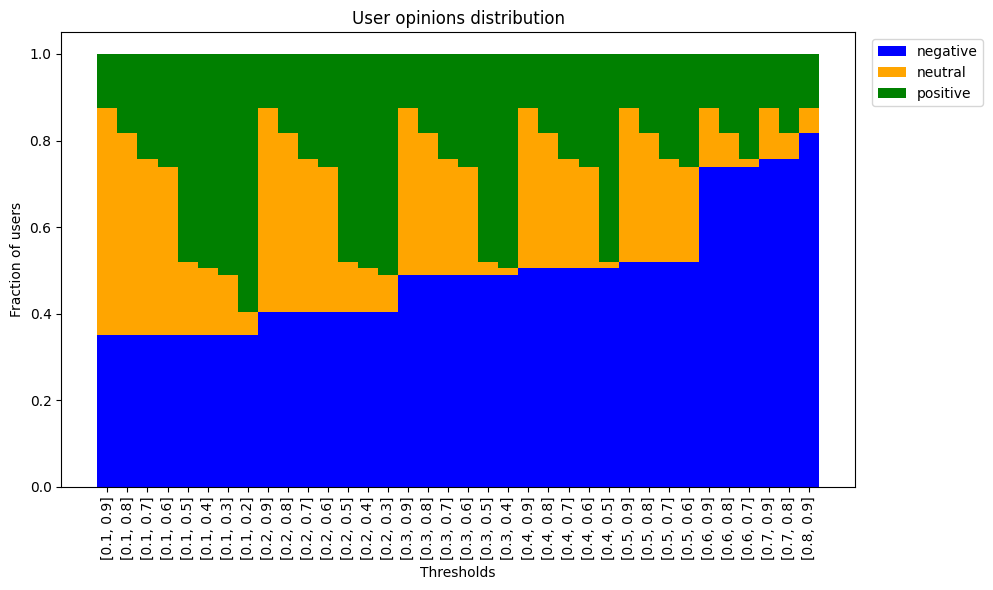

In [22]:
clf()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

labels = ["negative", "neutral", "positive"]
colors = ["blue", "orange", "green"]
width = 1

generate_bar_plot(ax, data_to_plot_two_thrs)

# # x infos
# # set x axis labels
ax.set_xlabel("Thresholds")
ax.set_xticks(1:length(two_thrs))
ax.set_xticklabels(two_thrs_labels, rotation=90)

# # set y axis labels
ax.set_ylabel("Fraction of users")

# # set titles
ax.set_title("User opinions distribution")

ax.legend(labels, loc="upper right", bbox_to_anchor=(1.17, 1.0))

plt.tight_layout();

## Three thresholds - four bands

In [23]:
thrs_vector = three_thrs
opinions_per_3thrs = Array{Array{Int, 1}, 1}()
;

In [25]:
for thr in thrs_vector
    opinions = Array{Int, 1}()
 
    for last_op in last_opinions
        binned_op = GrootSim._binning_opinions([last_op], thr)
 
         length(something.(binned_op)) > 1 && println("error")
 
        push!(opinions, something.(binned_op)[1])
    end
 
     push!(opinions_per_3thrs, opinions)
 end

In [26]:
# prepare the data to plot -> stacked bar chart
data_to_plot_three_thrs = prepare_data(opinions_per_3thrs, 3)

84-element Vector{Vector{Float64}}:
 [0.35003066857493353, 0.05295440605193212, 0.086485381312615, 0.5105295440605193]
 [0.35003066857493353, 0.05295440605193212, 0.10216043072309684, 0.4948544946500375]
 [0.35003066857493353, 0.05295440605193212, 0.11606351802630682, 0.4809514073468275]
 [0.35003066857493353, 0.05295440605193212, 0.3361957336604648, 0.26081919171266954]
 [0.35003066857493353, 0.05295440605193212, 0.3542561166768895, 0.2427588086962448]
 [0.35003066857493353, 0.05295440605193212, 0.41348054249301436, 0.18353438288011995]
 [0.35003066857493353, 0.05295440605193212, 0.4722960539766919, 0.12471887139644244]
 [0.35003066857493353, 0.13943978736454712, 0.015675049410481836, 0.4948544946500375]
 [0.35003066857493353, 0.13943978736454712, 0.029578136713691815, 0.4809514073468275]
 [0.35003066857493353, 0.13943978736454712, 0.2497103523478498, 0.26081919171266954]
 [0.35003066857493353, 0.13943978736454712, 0.26777073536427454, 0.2427588086962448]
 [0.35003066857493353, 0.1394

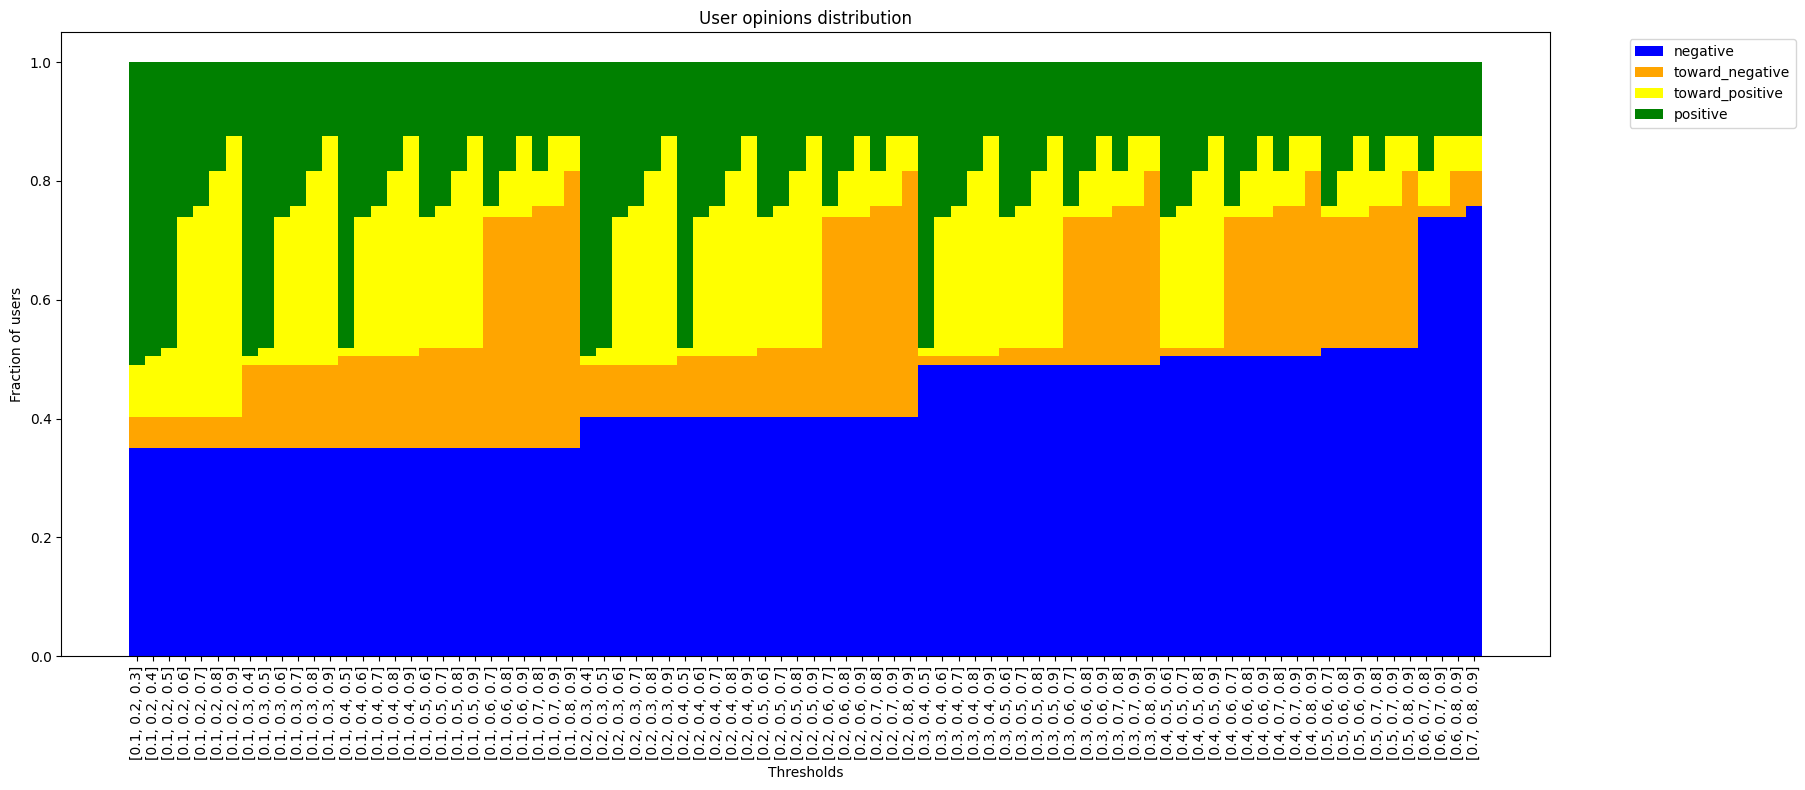

In [27]:
clf()

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

labels = ["negative", "toward_negative", "toward_positive", "positive"]
colors = ["blue", "orange", "yellow", "green"]
width = 1

generate_bar_plot(ax, data_to_plot_three_thrs)

# # x infos
# # set x axis labels
ax.set_xlabel("Thresholds")
ax.set_xticks(1:length(three_thrs))
ax.set_xticklabels(three_thrs_labels, rotation=90)

# # set y axis labels
ax.set_ylabel("Fraction of users")

# # set titles
ax.set_title("User opinions distribution")

ax.legend(labels, loc="upper right", bbox_to_anchor=(1.17, 1.0))

plt.tight_layout();